In [1]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np

In [2]:
imagegen = ImageDataGenerator()
train = imagegen.flow_from_directory("dataset/train/", class_mode="categorical", shuffle=False, batch_size=128, target_size=(224, 224))
val = imagegen.flow_from_directory("dataset/valid/", class_mode="categorical", shuffle=False, batch_size=128, target_size=(224, 224))

Found 1920 images belonging to 4 classes.
Found 240 images belonging to 4 classes.


In [3]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, InputLayer, BatchNormalization, Dropout

# build a sequential model
model = Sequential()
model.add(InputLayer(input_shape=(224, 224, 3)))

# 1st conv block
model.add(Conv2D(25, (5, 5), activation='relu', strides=(1, 1), padding='same'))
model.add(MaxPool2D(pool_size=(2, 2), padding='same'))
# 2nd conv block
model.add(Conv2D(50, (5, 5), activation='relu', strides=(2, 2), padding='same'))
model.add(MaxPool2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization())
# 3rd conv block
model.add(Conv2D(70, (3, 3), activation='relu', strides=(2, 2), padding='same'))
model.add(MaxPool2D(pool_size=(2, 2), padding='valid'))
model.add(BatchNormalization())
# ANN block
model.add(Flatten())
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=100, activation='relu'))
model.add(Dropout(0.25))
# output layer
model.add(Dense(units=4, activation='softmax'))

# compile model
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])


In [4]:
# fit on data for 30 epochs
model_fit = model.fit(train, epochs=20, validation_data=val)

Epoch 1/20


15/15 [==============================] - 20s 1s/step - loss: 1.9600 - accuracy: 0.2161 - val_loss: 2.4504 - val_accuracy: 0.3208
Epoch 2/20
15/15 [==============================] - 15s 965ms/step - loss: 1.3316 - accuracy: 0.4000 - val_loss: 3.6799 - val_accuracy: 0.2833
Epoch 3/20
15/15 [==============================] - 14s 940ms/step - loss: 1.1440 - accuracy: 0.4833 - val_loss: 2.1338 - val_accuracy: 0.3125
Epoch 4/20
15/15 [==============================] - 14s 944ms/step - loss: 1.0247 - accuracy: 0.5542 - val_loss: 1.2754 - val_accuracy: 0.4417
Epoch 5/20
15/15 [==============================] - 15s 971ms/step - loss: 0.8731 - accuracy: 0.6161 - val_loss: 1.9836 - val_accuracy: 0.3167
Epoch 6/20
15/15 [==============================] - 14s 957ms/step - loss: 0.8084 - accuracy: 0.6740 - val_loss: 1.2484 - val_accuracy: 0.4250
Epoch 7/20
15/15 [==============================] - 14s 926ms/step - loss: 0.5824 - accuracy: 0.7781 - val_loss: 1.1121 - val_accuracy: 0.4875


In [3]:
from keras.applications import VGG16

# include top should be False to remove the softmax layer
pretrained_model = VGG16(include_top=False, weights='imagenet')
pretrained_model.summary()



Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0   

In [4]:
from keras.utils import to_categorical
# extract train and val features
vgg_features_train = pretrained_model.predict(train)
vgg_features_val = pretrained_model.predict(val)

2/2 [==============================] - 16s 7s/step


In [5]:
# OHE target column
train_target = to_categorical(train.labels)
val_target = to_categorical(val.labels)

In [7]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, InputLayer, BatchNormalization, Dropout

model2 = Sequential()
model2.add(Flatten(input_shape=(7,7,512)))
model2.add(Dense(100, activation='relu'))
model2.add(Dropout(0.5))
model2.add(BatchNormalization())
model2.add(Dense(4, activation='softmax'))

# compile the model
model2.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy')

model2.summary()

# train model using features generated from VGG16 model
model_fit2 = model2.fit(vgg_features_train, train_target, epochs=50, batch_size=128, validation_data=(vgg_features_val, val_target))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 100)               2508900   
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 batch_normalization (Batch  (None, 100)               400       
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 4)                 404       
                                                                 
Total params: 2509704 (9.57 MB)
Trainable params: 2509504 (9.57 MB)
Non-trainable params: 200 (800.00 Byte)
_____________

In [18]:
test = imagegen.flow_from_directory("dataset/test/", class_mode="categorical", shuffle=False, batch_size=128, target_size=(224, 224))
test_target = to_categorical(test.labels)
vgg_features_test = pretrained_model.predict(test)
model2.evaluate(vgg_features_test, test_target)

Found 240 images belonging to 4 classes.


8/8 [==============================] - 0s 6ms/step - loss: 0.3742 - accuracy: 0.9083


[0.37418147921562195, 0.9083333611488342]

In [21]:
y_pred1 = model2.predict(vgg_features_test)
y_pred2 = y_pred1.argmax(axis = 1)

8/8 [==============================] - 0s 3ms/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 3, 3, 3,
       3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 3, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 0, 0, 2, 2, 3, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
      dtype=int64)

In [22]:
import itertools
from sklearn.metrics import confusion_matrix

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15): 
  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
             horizontalalignment="center",
             color="white" if cm[i, j] > threshold else "black",
             size=text_size)

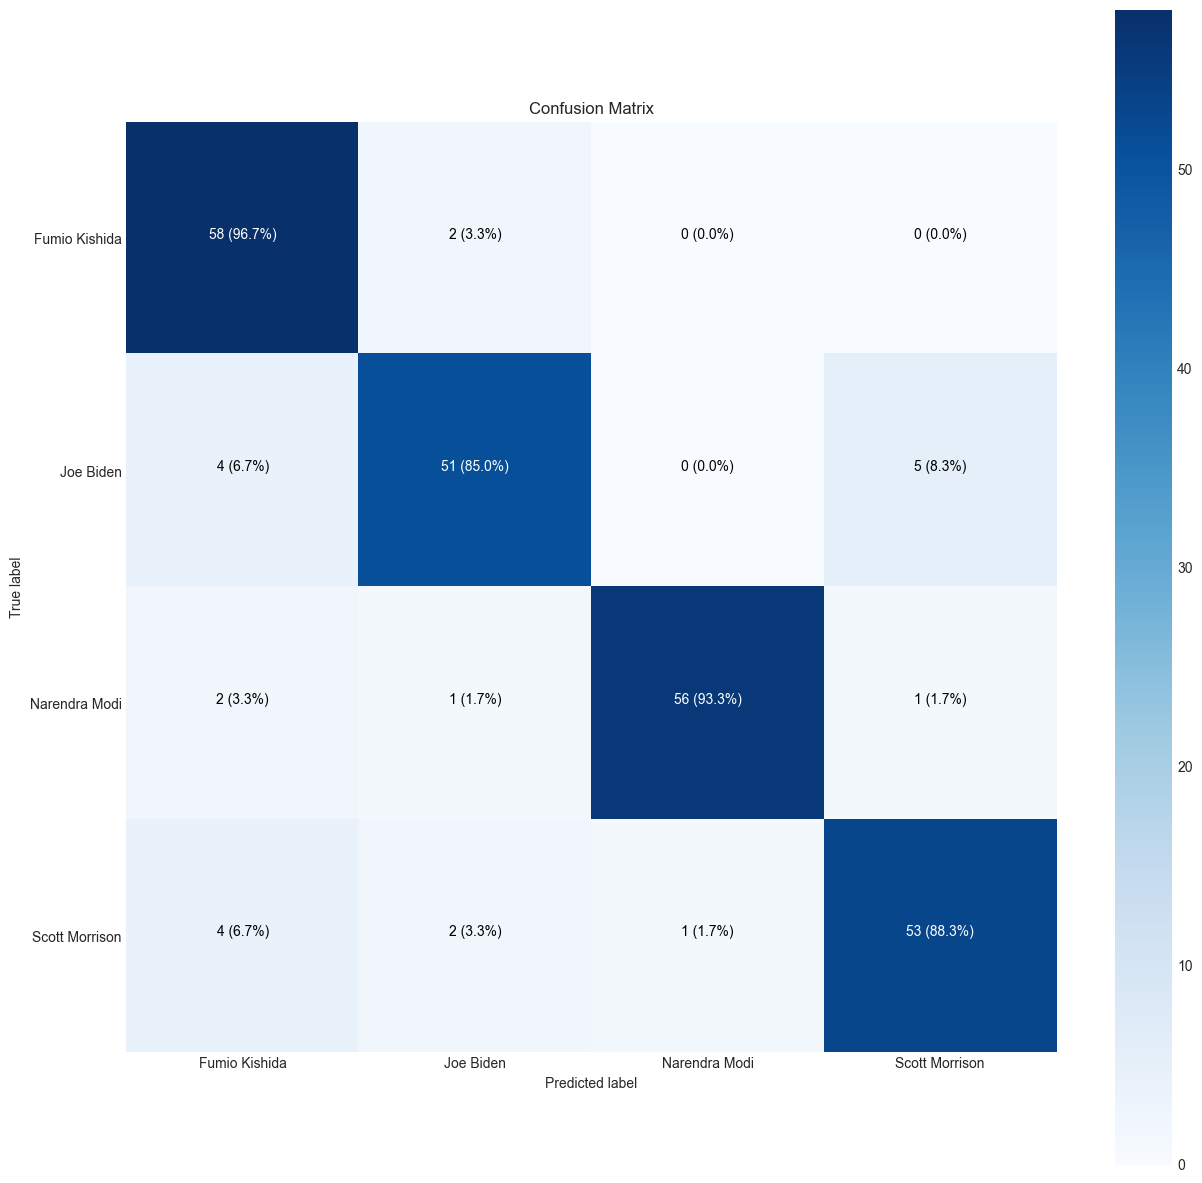

In [28]:

class_names = ["Fumio Kishida", "Joe Biden", "Narendra Modi", "Scott Morrison"]
test_target_np = test_target.argmax(axis=1)
plt.style.use('seaborn-v0_8-dark')
make_confusion_matrix(y_true=test_target_np, 
                      y_pred=y_pred2,
                      classes=class_names,
                      figsize=(15, 15),
                      text_size=10)

In [29]:
from sklearn.metrics import classification_report
print(classification_report(test_target_np, y_pred2, target_names=class_names))

                precision    recall  f1-score   support

 Fumio Kishida       0.85      0.97      0.91        60
     Joe Biden       0.91      0.85      0.88        60
 Narendra Modi       0.98      0.93      0.96        60
Scott Morrison       0.90      0.88      0.89        60

      accuracy                           0.91       240
     macro avg       0.91      0.91      0.91       240
  weighted avg       0.91      0.91      0.91       240



1/1 [==============================] - 0s 90ms/step


array([[1.8607006e-05, 7.5368363e-05, 3.6581809e-05, 9.9986947e-01]],
      dtype=float32)

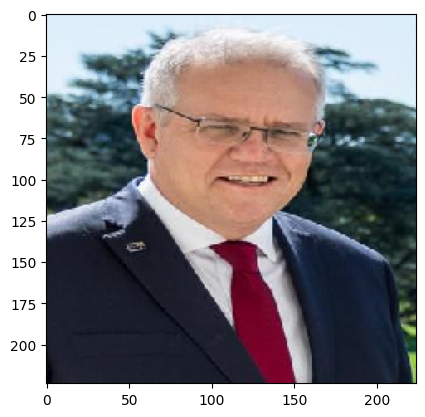

In [16]:
img = image.load_img("dataset/test/scott_morrison/ScottMorrison0_c.jpg", target_size=(224,224,3))
plt.imshow(img)
temp = image.img_to_array(img)
temp = np.expand_dims(temp,axis=0)
images = np.vstack([temp])
val = pretrained_model.predict(images)
val2 = model2.predict(val)
val2
# if val[0][0]>val[0][1] and val[0][0]>val[0][2] and val[0][0]>val[0][3]:
#     print("Fumio Kishida")
# elif val[0][1]>val[0][0] and val[0][1]>val[0][2] and val[0][1]>val[0][3]:
#     print("Joe Biden")
# elif val[0][2]>val[0][0] and val[0][2]>val[0][1] and val[0][2]>val[0][3]:
#     print("Narendra Modi")
# elif val[0][3]>val[0][0] and val[0][3]>val[0][1] and val[0][3]>val[0][2]:
#     print("Scott Morrison")

In [19]:
import cv2

img2 = cv2.imread("dataset/test/scott_morrison/ScottMorrison0_c.jpg")
print(img2.shape)

(300, 300, 3)
